In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:4


In [5]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

# Hyperparameter optimized for 9/7

# args = {
#     'processor':         'GENConv',
#     'head':              'regression',     
#     'num_layers':        4,
#     'num_mlp_layers':    2,
#     'aggr':              'max',
#     'batch_size':        8,
#     'node_feature_dim':  5,
#     'edge_feature_dim':  1,
#     'graph_feature_dim': 2,
#     'hidden_dim':        58,
#     'output_dim':        1,
#     'dropout':           0.066,
#     'epochs':            80,
#     'opt':               'adagrad',
#     'opt_scheduler':     'none',
#     'opt_restart':       0,
#     'weight_decay':      5e-3,
#     'lr':                0.0022434,
#     'device':            device,
#     'noise':             0 # Set to 0 to not train on noisy features
# }

# Hyperparam optimized for 6,10

args = {
    'processor':         'GENConv',
    'head':              'regression',     
    'num_layers':        5,
    'num_mlp_layers':    5,
    'aggr':              'max',
    'batch_size':        2,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        128,
    'output_dim':        1,
    'dropout':           0.0115,
    'epochs':            32,
    'opt':               'adagrad',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0083,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

# Hyperparam optimized for 10,6

# args = {
#     'processor':         'GENConv',
#     'head':              'regression',     
#     'num_layers':        3,
#     'num_mlp_layers':    3,
#     'aggr':              'max',
#     'batch_size':        8,
#     'node_feature_dim':  5,
#     'edge_feature_dim':  1,
#     'graph_feature_dim': 2,
#     'hidden_dim':        32,
#     'output_dim':        1,
#     'dropout':           0.0306,
#     'epochs':            64,
#     'opt':               'adagrad',
#     'opt_scheduler':     'none',
#     'opt_restart':       0,
#     'weight_decay':      5e-3,
#     'lr':                0.0121,
#     'device':            device,
#     'noise':             0 # Set to 0 to not train on noisy features
# }

In [31]:
train_num = 200; test_num = 100
node_config = (6,10)

# er_config = {
#     'graph_type': 'ER',
#     'p': 0.75,
#     'weighted': True
# }
# ba_config = {
#     'graph_type': 'BA',
#     'ba_param': 2,
#     'weighted': True
# }
# geom_config = {
#     'graph_type': 'GEOM',
#     'threshold': 0.2,
#     'scaling': 1 / np.sqrt(2)
# }

# train_instances = [
#         *ig.sample_instances(*node_config, train_num, rng, args, **er_config),
#         *ig.sample_instances(*node_config, train_num, rng, args, **ba_config),
#         *ig.sample_instances(*node_config, train_num, rng, args, **geom_config),
#     ]

# test_instances = [
#         *ig.sample_instances(*node_config, test_num, rng, args, **er_config),
#         *ig.sample_instances(*node_config, test_num, rng, args, **ba_config),
#         *ig.sample_instances(*node_config, test_num, rng, args, **geom_config),
#     ]

node_configs = util.node_configs_gnn1

rng = np.random.default_rng()


train_instances = [
        ig.sample_instances(node_config[0], node_config[1], train_num, rng, args, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]
test_instances = [
        ig.sample_instances(node_config[0], node_config[1], test_num, rng, args, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]
# flat map the instances
train_instances = [instance for instances in train_instances for instance in instances]
test_instances = [instance for instances in test_instances for instance in instances]

train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

KeyboardInterrupt: 

In [12]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


TRAINING LOSS: 0.028850805054291963


Training:   2%|▏         | 1/64 [00:18<19:09, 18.24s/Epochs]

TEST LOSS: 0.011462138034403324
TEST ACCURACY: 0.8618913888931274


Training:   3%|▎         | 2/64 [00:31<15:31, 15.02s/Epochs]

TRAINING LOSS: 0.014420568845636205


Training:   5%|▍         | 3/64 [00:44<14:24, 14.18s/Epochs]

TRAINING LOSS: 0.01246313517299067


Training:   6%|▋         | 4/64 [00:57<13:53, 13.90s/Epochs]

TRAINING LOSS: 0.011122692774260066
TRAINING LOSS: 0.01135940055338314


Training:   8%|▊         | 5/64 [01:17<15:50, 16.11s/Epochs]

TEST LOSS: 0.007629333063960075
TEST ACCURACY: 0.8796816468238831


Training:   9%|▉         | 6/64 [01:31<14:45, 15.26s/Epochs]

TRAINING LOSS: 0.010886654084933518


Training:  11%|█         | 7/64 [01:44<13:49, 14.55s/Epochs]

TRAINING LOSS: 0.010118755225479968


Training:  12%|█▎        | 8/64 [01:58<13:26, 14.40s/Epochs]

TRAINING LOSS: 0.010081936899630517
TRAINING LOSS: 0.010044732564482075


Training:  14%|█▍        | 9/64 [02:17<14:25, 15.74s/Epochs]

TEST LOSS: 0.01670609414577484
TEST ACCURACY: 0.8501873016357422


Training:  16%|█▌        | 10/64 [02:30<13:36, 15.11s/Epochs]

TRAINING LOSS: 0.009795618658289628


Training:  17%|█▋        | 11/64 [02:43<12:47, 14.49s/Epochs]

TRAINING LOSS: 0.009336226979718911


Training:  19%|█▉        | 12/64 [02:56<12:01, 13.88s/Epochs]

TRAINING LOSS: 0.009306606078573936
TRAINING LOSS: 0.009223970913363763


Training:  20%|██        | 13/64 [03:13<12:40, 14.92s/Epochs]

TEST LOSS: 0.012229776941239834
TEST ACCURACY: 0.8857678174972534


Training:  22%|██▏       | 14/64 [03:26<11:59, 14.39s/Epochs]

TRAINING LOSS: 0.009120951138622796


Training:  23%|██▎       | 15/64 [03:41<11:43, 14.35s/Epochs]

TRAINING LOSS: 0.009107687854257623


Training:  25%|██▌       | 16/64 [03:53<11:06, 13.89s/Epochs]

TRAINING LOSS: 0.008690500047164906
TRAINING LOSS: 0.008741241584308673


Training:  27%|██▋       | 17/64 [04:13<12:05, 15.44s/Epochs]

TEST LOSS: 0.00981796532869339
TEST ACCURACY: 0.8773408532142639


Training:  28%|██▊       | 18/64 [04:25<11:14, 14.66s/Epochs]

TRAINING LOSS: 0.00872619575467724


Training:  30%|██▉       | 19/64 [04:38<10:34, 14.10s/Epochs]

TRAINING LOSS: 0.008494508219115153


Training:  31%|███▏      | 20/64 [04:51<10:07, 13.80s/Epochs]

TRAINING LOSS: 0.008807655271656856
TRAINING LOSS: 0.008197312576571691


Training:  33%|███▎      | 21/64 [05:10<11:01, 15.38s/Epochs]

TEST LOSS: 0.008266539312899113
TEST ACCURACY: 0.8834269642829895


Training:  34%|███▍      | 22/64 [05:24<10:20, 14.77s/Epochs]

TRAINING LOSS: 0.008350407883474008


Training:  36%|███▌      | 23/64 [05:37<09:48, 14.34s/Epochs]

TRAINING LOSS: 0.008047851634940489


Training:  38%|███▊      | 24/64 [05:50<09:21, 14.04s/Epochs]

TRAINING LOSS: 0.00837114258760124
TRAINING LOSS: 0.00808062977050056


Training:  39%|███▉      | 25/64 [06:08<09:53, 15.21s/Epochs]

TEST LOSS: 0.007144153583794832
TEST ACCURACY: 0.8852996230125427


Training:  41%|████      | 26/64 [06:21<09:14, 14.60s/Epochs]

TRAINING LOSS: 0.008150270580938345


Training:  42%|████▏     | 27/64 [06:36<09:02, 14.65s/Epochs]

TRAINING LOSS: 0.00820444961095135


Training:  44%|████▍     | 28/64 [06:50<08:41, 14.50s/Epochs]

TRAINING LOSS: 0.00823113216250412
TRAINING LOSS: 0.007968295153907755


Training:  45%|████▌     | 29/64 [07:10<09:16, 15.91s/Epochs]

TEST LOSS: 0.0064885239116847515
TEST ACCURACY: 0.8848314881324768


Training:  47%|████▋     | 30/64 [07:23<08:31, 15.05s/Epochs]

TRAINING LOSS: 0.007697750890589777


Training:  48%|████▊     | 31/64 [07:36<08:03, 14.64s/Epochs]

TRAINING LOSS: 0.008068742978597587


Training:  50%|█████     | 32/64 [07:50<07:34, 14.21s/Epochs]

TRAINING LOSS: 0.007868144922204109
TRAINING LOSS: 0.007906124645030784


Training:  52%|█████▏    | 33/64 [08:08<08:04, 15.62s/Epochs]

TEST LOSS: 0.005923676770180464
TEST ACCURACY: 0.891853928565979


Training:  53%|█████▎    | 34/64 [08:21<07:19, 14.66s/Epochs]

TRAINING LOSS: 0.007739094291952734


Training:  55%|█████▍    | 35/64 [08:34<06:52, 14.21s/Epochs]

TRAINING LOSS: 0.007811329378959211


Training:  56%|█████▋    | 36/64 [08:48<06:32, 14.01s/Epochs]

TRAINING LOSS: 0.007760728744055604
TRAINING LOSS: 0.007853148598531002


Training:  58%|█████▊    | 37/64 [09:06<06:57, 15.46s/Epochs]

TEST LOSS: 0.007013262249529362
TEST ACCURACY: 0.8857678174972534


Training:  59%|█████▉    | 38/64 [09:21<06:35, 15.19s/Epochs]

TRAINING LOSS: 0.007668244523696822


Training:  61%|██████    | 39/64 [09:34<06:05, 14.62s/Epochs]

TRAINING LOSS: 0.007799954215780574


Training:  62%|██████▎   | 40/64 [09:47<05:38, 14.09s/Epochs]

TRAINING LOSS: 0.007565395965241335
TRAINING LOSS: 0.00755600389468234


Training:  64%|██████▍   | 41/64 [10:05<05:51, 15.30s/Epochs]

TEST LOSS: 0.008346356451511383
TEST ACCURACY: 0.8951311111450195


Training:  66%|██████▌   | 42/64 [10:18<05:21, 14.63s/Epochs]

TRAINING LOSS: 0.007606427620519944


Training:  67%|██████▋   | 43/64 [10:31<04:58, 14.19s/Epochs]

TRAINING LOSS: 0.007263321965780185


Training:  69%|██████▉   | 44/64 [10:44<04:34, 13.71s/Epochs]

TRAINING LOSS: 0.007537683884508371
TRAINING LOSS: 0.007670662055924724


Training:  70%|███████   | 45/64 [11:02<04:44, 14.97s/Epochs]

TEST LOSS: 0.00673783989623189
TEST ACCURACY: 0.8857678174972534


Training:  72%|███████▏  | 46/64 [11:15<04:16, 14.27s/Epochs]

TRAINING LOSS: 0.007377504576629294


Training:  73%|███████▎  | 47/64 [11:28<03:56, 13.91s/Epochs]

TRAINING LOSS: 0.007441875148100451


Training:  75%|███████▌  | 48/64 [11:41<03:38, 13.67s/Epochs]

TRAINING LOSS: 0.0074695075839736865
TRAINING LOSS: 0.007349478578115136


Training:  77%|███████▋  | 49/64 [11:59<03:43, 14.91s/Epochs]

TEST LOSS: 0.0068368748761713505
TEST ACCURACY: 0.8932584524154663


Training:  78%|███████▊  | 50/64 [12:12<03:21, 14.38s/Epochs]

TRAINING LOSS: 0.007342615678952064


Training:  80%|███████▉  | 51/64 [12:26<03:04, 14.22s/Epochs]

TRAINING LOSS: 0.007318576085203543


Training:  81%|████████▏ | 52/64 [12:38<02:45, 13.79s/Epochs]

TRAINING LOSS: 0.0073549690732256
TRAINING LOSS: 0.007461235700355026


Training:  83%|████████▎ | 53/64 [12:57<02:47, 15.25s/Epochs]

TEST LOSS: 0.006041478831321001
TEST ACCURACY: 0.887172281742096


Training:  84%|████████▍ | 54/64 [13:10<02:25, 14.58s/Epochs]

TRAINING LOSS: 0.007329630756946356


Training:  86%|████████▌ | 55/64 [13:23<02:07, 14.17s/Epochs]

TRAINING LOSS: 0.007329738154714323


Training:  88%|████████▊ | 56/64 [13:36<01:51, 13.88s/Epochs]

TRAINING LOSS: 0.007212535845351792
TRAINING LOSS: 0.007491398314180777


Training:  89%|████████▉ | 57/64 [13:54<01:43, 14.84s/Epochs]

TEST LOSS: 0.007619963958859444
TEST ACCURACY: 0.8810861706733704


Training:  91%|█████████ | 58/64 [14:07<01:26, 14.35s/Epochs]

TRAINING LOSS: 0.007297848047512253


Training:  92%|█████████▏| 59/64 [14:21<01:11, 14.23s/Epochs]

TRAINING LOSS: 0.007153117302340182


Training:  94%|█████████▍| 60/64 [14:35<00:56, 14.21s/Epochs]

TRAINING LOSS: 0.007188520581802345
TRAINING LOSS: 0.007242255450129418


Training:  95%|█████████▌| 61/64 [14:52<00:45, 15.04s/Epochs]

TEST LOSS: 0.0069217924028635025
TEST ACCURACY: 0.8904494643211365


Training:  97%|█████████▋| 62/64 [15:04<00:28, 14.30s/Epochs]

TRAINING LOSS: 0.007271020632637275


Training:  98%|█████████▊| 63/64 [15:18<00:14, 14.19s/Epochs]

TRAINING LOSS: 0.00715948293578657


Training: 100%|██████████| 64/64 [15:31<00:00, 14.56s/Epochs]

TRAINING LOSS: 0.007299659005355299


In [9]:
save(GNN, args, 'GNN2_hyperparam_tuned')

In [ ]:
# GNN, args = load('GNN2', device)

In [ ]:
from gnn_library.OBM_greedy import OBM_Greedy
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = [(threshold, OBM_Threshold_Greedy(threshold)) for threshold in thresholds]

seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

greedy_ratios = {}
for threshold, model in thresholded_greedy_models: 
    ratio = evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=eval_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
pp_output(ratios2, _, show_log=False)
print(greedy_ratios)

In [ ]:
max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(max_threshold, greedy_ratios[max_threshold])

# Pivot to feature-generated graphs

In [ ]:
def get_location_graph(city):
	location_graph = ox.graph_from_place(city, network_type="drive")
	location_graph = ox.speed.add_edge_speeds(location_graph)
	location_graph = ox.speed.add_edge_travel_times(location_graph)
	return {'location_graph': location_graph, 'city': city}

In [ ]:
piedmont = get_location_graph("Piedmont, California, USA")
# san_francisco = get_location_graph("San Francisco, California, USA")
founex = get_location_graph("Founex, Switzerland")
carmel = get_location_graph("Carmel, Indiana, USA")
geneva = get_location_graph("Geneva, Switzerland")

In [ ]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 0.75,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
# osmnx_config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **er_config),
        *ig.sample_instances(8, 8, train_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(8, 8, test_num, rng, **er_config),
        *ig.sample_instances(8, 8, test_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [22]:
from tqdm import tqdm
import util
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

# osmnx_config1 = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# osmnx_config2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': geneva['location_graph']
# }
# osmnx_config3 = {
#     'graph_type': 'OSMNX',
#     'location_graph': carmel['location_graph']
# }

node_configs = util.node_configs_GNN1
graph_configs = util.graph_configs_standard
train_num = 5
train_instances = [
        ig.sample_instances(node_config[0], node_config[1], train_num, rng, args.__dict__, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]

# flat map the train instances
train_instances = [instance for instances in train_instances for instance in instances]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio, _ = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio['learned'])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

100%|██████████| 101/101 [29:33<00:00, 17.56s/it]

Best threshold value: 0.0 achieves CR: 0.05581373962215269


In [16]:
print(greedy_ratios)

{0.0: 0.991188005856922, 0.01: 0.991188005856922, 0.02: 0.991188005856922, 0.03: 0.991188005856922, 0.04: 0.991188005856922, 0.05: 0.991188005856922, 0.06: 0.991188005856922, 0.07: 0.991188005856922, 0.08: 0.991188005856922, 0.09: 0.991188005856922, 0.1: 0.991188005856922, 0.11: 0.991188005856922, 0.12: 0.991188005856922, 0.13: 0.991188005856922, 0.14: 0.991188005856922, 0.15: 0.991188005856922, 0.16: 0.991188005856922, 0.17: 0.991188005856922, 0.18: 0.991188005856922, 0.19: 0.991188005856922, 0.2: 0.991188005856922, 0.21: 0.991188005856922, 0.22: 0.991188005856922, 0.23: 0.991188005856922, 0.24: 0.991188005856922, 0.25: 0.9902019295044397, 0.26: 0.9902019295044397, 0.27: 0.9902019295044397, 0.28: 0.9902019295044397, 0.29: 0.9902019295044397, 0.3: 0.9902019295044397, 0.31: 0.9902019295044397, 0.32: 0.9902019295044397, 0.33: 0.9902019295044397, 0.34: 0.9902019295044397, 0.35000000000000003: 0.9902019295044397, 0.36: 0.9902019295044397, 0.37: 0.9902019295044397, 0.38: 0.9843320526626002,

## Evaluation

In [ ]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 25
eval_instances = [
        *ig.sample_instances(m, n, eval_num, rng, **er_config),
        *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
]

ratios = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)


ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[THRESHOLD_MODEL],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)
print(f"Thresholded greedy: {np.mean(ratios2[0]).round(4)}")


## Box plot baseline evaluation

In [4]:
GNN, args = load('GNN1_hyperparam_tuned', device)

In [32]:
import gnn_library.util as util
num_trials = 40
threshold = 0 # TODO set up value
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

models = [("GNN", GNN)]
t_greedy = OBM_Threshold_Greedy(threshold) 

node_configs = util.node_configs_gnn1
graph_configs = util.graph_configs_standard

data = {node_config: {} for node_config in node_configs}

for node_config in node_configs:
    for graph_config in graph_configs:
            print(graph_config)
            seed = np.random.randint(0, 500000)
            rng = np.random.default_rng(seed)
            instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


            rng = np.random.default_rng(seed)

            for model_name, model in models:
                cr_ratios, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[model],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=5,
                    baselines=['greedy', 'lp_rounding'],
                )

                data[node_config][graph_config['graph_type']] = cr_ratios

                t_greedy_ratio, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[t_greedy],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=5,
                )

                # Threshold greedy is considered as a model here
                data[node_config][graph_config['graph_type']]['threshold_greedy'] = t_greedy_ratio['learned']


{'graph_type': 'ER', 'p': 0.5, 'weighted': True}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'graph_type': 'ER', 'p': 0.75, 'weighted': True}
{'graph_type': 'ER', 'p': 0.9, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
{'graph_type': 'OSMNX', 'location': 'Piedmont, California, USA'}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
{'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'graph_type': 'ER', 'p': 0.5, 'weighted': True}
{'graph_type': 'ER', 'p': 0.75, 'weighted': True}
{'graph_type': 'ER', 'p': 0.9, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
{'graph_type': 'OSMNX', 'location': 'Piedmont, California, USA'}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
{'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
import pickle

with open(f"saved_runs/box_plot_eval_gnn1_base_2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open(f'saved_runs/box_plot_eval_gnn1_base_2.pickle', 'rb') as handle:
    data_copy = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


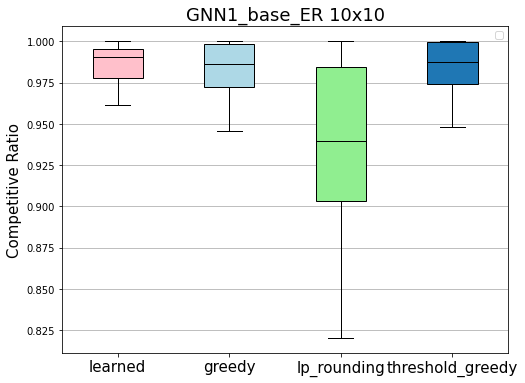

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


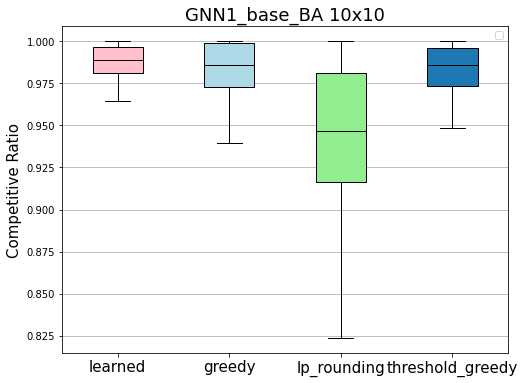

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


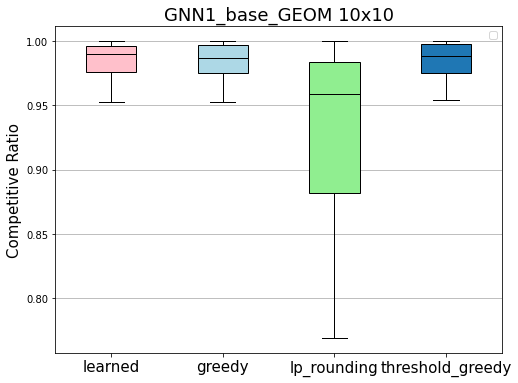

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


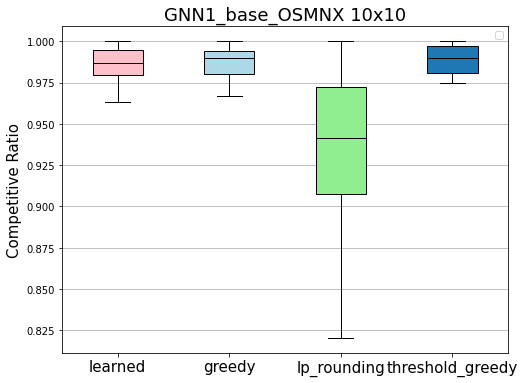

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


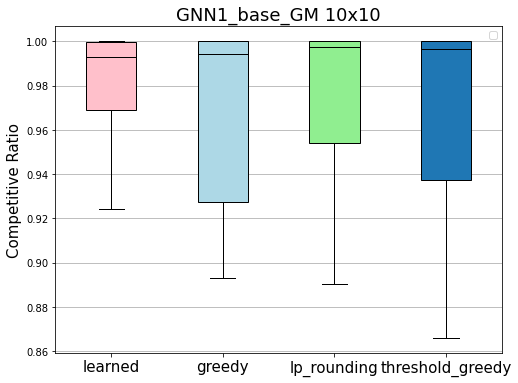

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


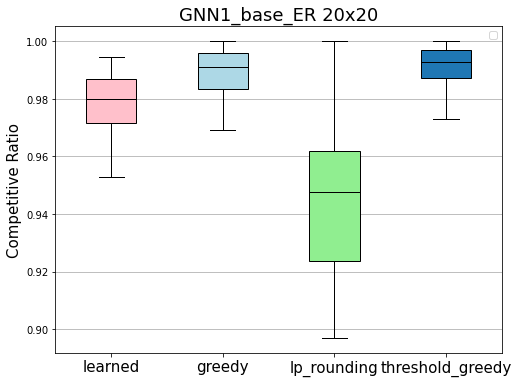

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


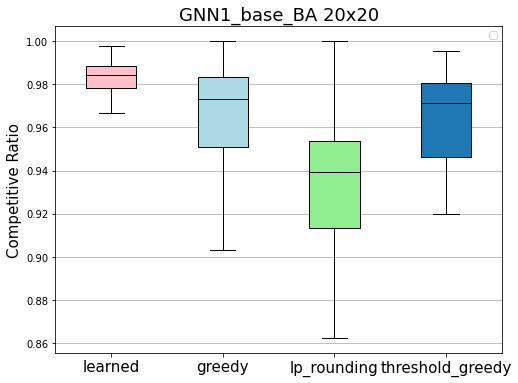

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


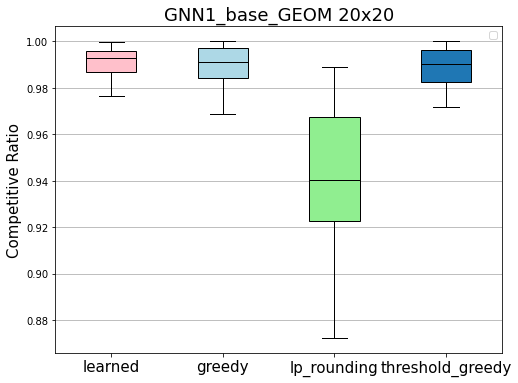

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


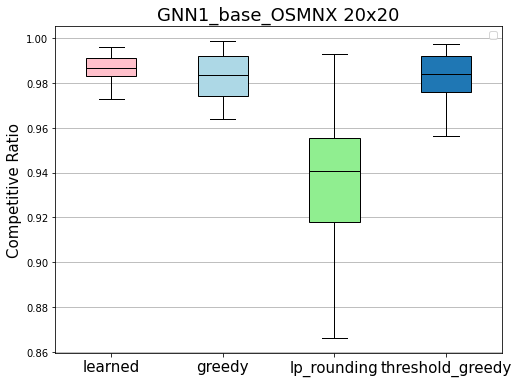

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


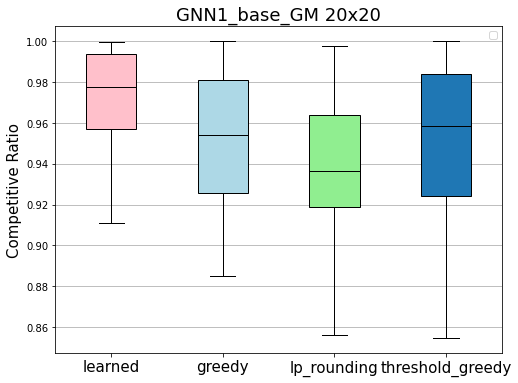

In [36]:
from util import _box_plots
for node_config in node_configs:
	_box_plots(data_copy[node_config], lambda graph_type: f"GNN1_base_{graph_type} {node_config[1]}x{node_config[0]}", colors = ['pink', 'lightblue', 'lightgreen'])

### Baseline ER/BA/GEOM evaluation

In [7]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 40, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

models = [("GNN", GNN)]

graph_configs = [
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    # {
    #     'graph_type': 'GEOM',
    #     'threshold': 0.2,
    #     'scaling': 1 / np.sqrt(2),
    #     'weighted': True
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


        rng = np.random.default_rng(seed)

        baselines = ['greedy']
        for model_name, model in models:
            cr_ratios = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[model],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                # baselines=['greedy', 'lp_rounding']
                baselines=baselines
            )

            baselines = []

            cr_ratios[model_name] = cr_ratios.pop("learned")

        data[graph_config['graph_type']].append(cr_ratios)

[0.25, 0.75, 1.25, 1.75, 2.25]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)


AttributeError: 'tuple' object has no attribute 'pop'

In [ ]:
from util import _plot_approx_ratios
_plot_approx_ratios(ratios, data, lambda graph_type: graph_type, confidence = 0.95)

In [ ]:
import matplotlib.pyplot as plt

ratios = [x/y for (x,y) in node_configs]

for graph_type, comp_ratios in data.items():
    aggregated_ratios = {}

    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

    fig = plt.figure(figsize=(8,6))
    for model, model_ratios in aggregated_ratios.items():
        plt.plot(ratios, model_ratios, label=model)

    title = f"{graph_type}"
    plt.title(title)
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/17_01_2024_{title}_no_probabilities.png")
    plt.show()


## Noise experiments

In [12]:
def create_noise_robust_models(noise_values):
    models = []
    for noise_value in noise_values:
        print(f"Training model for noise {noise_value}")
        args = {
            'processor':         'GENConv',
            'head':              'regression',     
            'num_layers':        3,
            'num_mlp_layers':    3,
            'aggr':              'max',
            'batch_size':        8,
            'node_feature_dim':  5,
            'edge_feature_dim':  1,
            'graph_feature_dim': 2,
            'hidden_dim':        32,
            'output_dim':        1,
            'dropout':           0.0306,
            'epochs':            64,
            'opt':               'adagrad',
            'opt_scheduler':     'none',
            'opt_restart':       0,
            'weight_decay':      5e-3,
            'lr':                0.0121,
            'device':            device,
            'noise':             noise_value # Set to 0 to not train on noisy features
        }

        train_num = 100; test_num = 30

        er_config = {
            'graph_type': 'ER',
            'p': 0.75,
            'weighted': True
        }
        ba_config = {
            'graph_type': 'BA',
            'ba_param': 4,
            'weighted': True
        }
        geom_config = {
            'graph_type': 'GEOM',
            'q': 0.25,
            'd': 2,
            'weighted': True
        }

        rng = np.random.default_rng()

        node_config = (10,6)

        train_instances = [
                *ig.sample_instances(*node_config, train_num, rng, args, **er_config),
                *ig.sample_instances(*node_config, train_num, rng, args, **ba_config),
                *ig.sample_instances(*node_config, train_num, rng, args, **geom_config),
            ]

        test_instances = [
                *ig.sample_instances(*node_config, test_num, rng, args, **er_config),
                *ig.sample_instances(*node_config, test_num, rng, args, **ba_config),
                *ig.sample_instances(*node_config, test_num, rng, args, **geom_config),
            ]


        train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
        test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

        train_loader = DataLoader(
            train_data,
            batch_size=args['batch_size'],
            shuffle=True,
            num_workers=4
        )

        test_loader = DataLoader(
            test_data,
            batch_size=args['batch_size'],
            shuffle=True,
            num_workers=4
        )


        _, _, _, GNN, _ = train(train_loader, test_loader, args)

        save(GNN, args, f'GNN_noise_{noise_value}')

        models.append((f"GNN_{args['noise']}", GNN))
    return models

In [3]:
def get_models(noise_values):
	models = []
	for noise_value in noise_values:
		GNN, _ = load(f"GNN_noise_{noise_value}", device)
		models.append((f"GNN_{args['noise']}", GNN))
	return models

In [17]:
# noise_values = np.linspace(0,3,20)[5:10]
# noise_values = np.linspace(0,3,20)
noise_values = np.linspace(0,1,21)
# models = create_noise_robust_models(noise_values)
models = get_models(noise_values)

In [18]:
import gnn_library.util as util
import pickle

num_trials = 100
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
node_configs = util.node_configs_gnn
graph_configs = util.graph_config2

threshold = 0.35 # TODO set up value
t_greedy = OBM_Threshold_Greedy(threshold) 

data = [{node_config:[] for node_config in node_configs} for _ in range(len(graph_configs))]
for data_index, graph_config in enumerate(graph_configs):
    print(f"current graph {graph_config}")
    for node_config in node_configs:
        for noise_value, model in zip(noise_values, models):
            print(f"Evaluating model for noise {noise_value}")

            seed = np.random.randint(0, 500000)
            rng = np.random.default_rng(seed)

            args['noise'] = noise_value
            instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)

            cr_ratios, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[model[1]],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                baselines=['greedy', 'lp_rounding']
            )

            t_greedy_ratio, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[t_greedy],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
            )

            cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

            data[data_index][node_config].append(cr_ratios)

            with open(f"saved_runs/temp_noise/noise2.pickle", 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

current graph {'graph_type': 'ER', 'p': 0.75, 'weighted': True}
Evaluating model for noise 0.0


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Evaluating model for noise 0.05
Evaluating model for noise 0.1
Evaluating model for noise 0.15000000000000002
Evaluating model for noise 0.2
Evaluating model for noise 0.25
Evaluating model for noise 0.30000000000000004
Evaluating model for noise 0.35000000000000003
Evaluating model for noise 0.4
Evaluating model for noise 0.45
Evaluating model for noise 0.5
Evaluating model for noise 0.55
Evaluating model for noise 0.6000000000000001
Evaluating model for noise 0.65
Evaluating model for noise 0.7000000000000001
Evaluating model for noise 0.75
Evaluating model for noise 0.8
Evaluating model for noise 0.8500000000000001
Evaluating model for noise 0.9
Evaluating model for noise 0.9500000000000001
Evaluating model for noise 1.0
current graph {'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 0.05
Evaluating model for noise 0.1
Evaluating model for noise 0.15000000000000002
Evaluating model for noise 0.2
Evaluating model for noise

In [ ]:
import pickle

with open(f"saved_runs/noise_saved3_2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open(f"saved_runs/noise_saved3_2.pickle", 'rb') as handle:
    data_copy = pickle.load(handle)

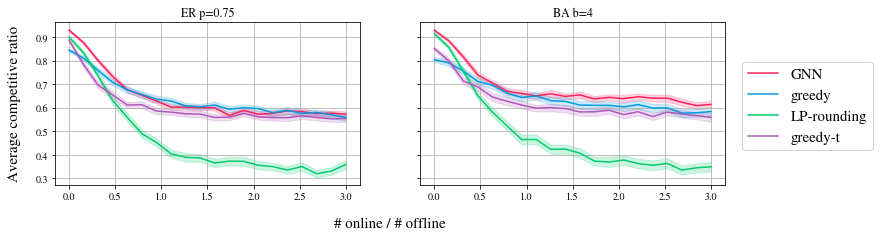

In [11]:
from util import _plot_approx_ratios
filtered_data = {frozenset(g.items()):d[node_configs[0]] for d,g in zip(data, graph_configs)}

_plot_approx_ratios(noise_values, filtered_data, lambda graph_type: f"noise {graph_config} {node_config[1]}x{node_config[0]}", confidence = 0.95)

## FEAT graph evaluation

In [ ]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.9,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.95,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    # plt.savefig(f"data/{title}.png")
    plt.show()


## OSMNX evaluation

In [ ]:
num_trials = 30
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

graph_configs = [
    {
        'graph_type': 'OSMNX',
        'location_graph': piedmont['location_graph'],
        'city': piedmont['city']
    },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': carmel['location_graph'],
    #     'city': carmel['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': geneva['location_graph'],
    #     'city': geneva['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': founex['location_graph'],
    #     'city': founex['city']
    # },
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['city']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        thresholded_greedy_ratios = [0]

        data[graph_config['city']].append(np.array(
            [
                gnn_learned_ratios,
                thresholded_greedy_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
print(ratios)
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[2]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[3]).mean())
        

    title = f"OSMNX_discard_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()



## Graph transferability

In [4]:
GNN, args = load('GNN2_hyperparam_tuned', device)

In [8]:
import gnn_library.util as util
num_trials = 40
node_configs = [(2*x, x) for x in np.arange(10, 40, 4)]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]


threshold = 0.35 # TODO set up value
t_greedy = OBM_Threshold_Greedy(threshold) 


graph_configs = util.graph_configs_standard

sizes = [x for (x,y) in node_configs]
print(sizes)

data = [[] for _ in range(len(graph_configs))]
for data_index, graph_config in enumerate(graph_configs):
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


        rng = np.random.default_rng(seed)

        cr_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        t_greedy_ratio, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[t_greedy],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
        )

        cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

        data[data_index].append(cr_ratios)

[20, 28, 36, 44, 52, 60, 68, 76]
(20, 10) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(28, 14) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(36, 18) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(44, 22) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix


(52, 26) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}


In [ ]:
import pickle

with open(f"saved_runs/transferability_gnn2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

with open(f'saved_runs/transferability_gnn2.pickle', 'rb') as handle:
    data_copy = pickle.load(handle)

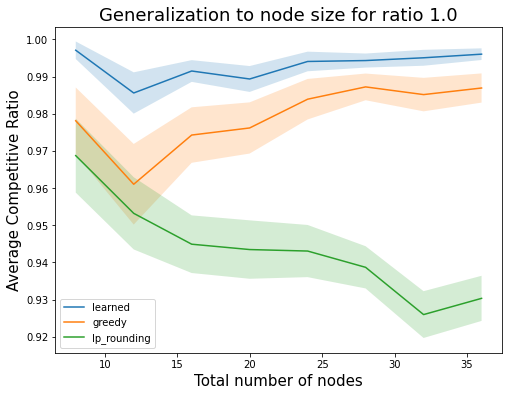

In [23]:
from util import _plot_approx_ratios
for graph_config, graph_data in data:
	_plot_approx_ratios(sizes, graph_data, lambda graph_type: f"Generalization to node size for ratio {2}", x_axis_name= "Number of online nodes", confidence = 0.95)

In [ ]:
import matplotlib.pyplot as plt

sizes = [x for (x,_) in node_configs]

aggregated_ratios = {}
for q, comp_ratios in data.items():
    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

fig = plt.figure(figsize=(8,6))
for model, ratios in aggregated_ratios.items():
    plt.plot(sizes, ratios, label=model)

title = f"16_01_2024_graph_transferability_{q}"
plt.title("Graph transferability NxN ratio - trained on 8x8")
plt.xlabel('Number of online nodes')
plt.ylabel('Average competitive ratio')
plt.legend()
plt.savefig(f"data/{title}.png")
plt.show()
